In [104]:
import numpy as np
import pandas as pd
import os
import time
import json
from glob import glob

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score


In [105]:
# Debug version - see what's wrong
data = []
skip_reasons = {'no_summary': 0, 'missing_pbp_keys': 0, 'missing_summary_keys': 0, 'empty_periods': 0, 'other_error': 0}

# Check first 5 files in detail
print("Debugging first 5 files:\n")
for pbp_file in pbp_files[:5]:
    game_id = os.path.basename(pbp_file).replace('pbp_', '').replace('.json', '')
    summary_file = f'./nba_data/summary_{game_id}.json'
    
    print(f"File: {game_id}")
    print(f"  Summary exists: {os.path.exists(summary_file)}")
    
    if not os.path.exists(summary_file):
        print(f"  SKIP: No summary\n")
        continue
    
    try:
        with open(pbp_file) as f:
            pbp = json.load(f)
        
        print(f"  PBP keys: {list(pbp.keys())[:5]}...")
        print(f"  Has 'home': {'home' in pbp}")
        print(f"  Has 'away': {'away' in pbp}")
        print(f"  Has 'periods': {'periods' in pbp}")
        
        if 'periods' in pbp:
            print(f"  Periods type: {type(pbp['periods'])}")
            print(f"  Periods length: {len(pbp['periods'])}")
            if len(pbp['periods']) > 0:
                print(f"  First period has {len(pbp['periods'][0].get('events', []))} events")
        
        with open(summary_file) as f:
            summary = json.load(f)
        
        print(f"  Summary has 'home': {'home' in summary}")
        print(f"  Summary has 'away': {'away' in summary}")
        
        if 'home' in summary and 'away' in summary:
            print(f"  ✓ SHOULD PROCESS THIS FILE")
        print()
        
    except Exception as e:
        print(f"  ERROR: {e}\n")

print("\n" + "="*60)
print("Now check: are the validation checks TOO STRICT?")

Debugging first 5 files:

File: b43f364d-1a8c-46ec-ae7e-8cbbefeeb16e
  Summary exists: True
  PBP keys: ['id', 'status', 'coverage', 'scheduled', 'duration']...
  Has 'home': True
  Has 'away': True
  Has 'periods': True
  Periods type: <class 'list'>
  Periods length: 5
  First period has 119 events
  Summary has 'home': True
  Summary has 'away': True
  ✓ SHOULD PROCESS THIS FILE

File: dee2f770-5d2e-4813-bf32-331ff558bd40
  Summary exists: True
  PBP keys: ['message']...
  Has 'home': False
  Has 'away': False
  Has 'periods': False
  Summary has 'home': False
  Summary has 'away': False

File: 6f6b9daf-1884-4dc0-950a-792db3ebdb09
  Summary exists: True
  PBP keys: ['message']...
  Has 'home': False
  Has 'away': False
  Has 'periods': False
  Summary has 'home': False
  Summary has 'away': False

File: 3afe12f1-4aec-4391-9f27-0bd061323ec8
  Summary exists: True
  PBP keys: ['message']...
  Has 'home': False
  Has 'away': False
  Has 'periods': False
  Summary has 'home': False
  Su

In [106]:
# Check what the error message is
with open(pbp_files[1]) as f:
    error_data = json.load(f)
    print("Error response:")
    print(error_data)

Error response:
{'message': 'Limit Exceeded'}


In [107]:
# Extract ALL available features from play-by-play
data = []
skip_reasons = {'no_summary': 0, 'missing_pbp_keys': 0, 'missing_summary_keys': 0, 'empty_periods': 0, 'other_error': 0}

for pbp_file in pbp_files:
    game_id = os.path.basename(pbp_file).replace('pbp_', '').replace('.json', '')
    summary_file = f'./nba_data/summary_{game_id}.json'
    
    if not os.path.exists(summary_file):
        skip_reasons['no_summary'] += 1
        continue
    
    try:
        with open(pbp_file) as f:
            pbp = json.load(f)
        with open(summary_file) as f:
            summary = json.load(f)
        
        # Validate structure
        if 'home' not in pbp or 'away' not in pbp or 'periods' not in pbp:
            skip_reasons['missing_pbp_keys'] += 1
            continue

        if not pbp.get('periods') or len(pbp.get('periods', [])) == 0:
            skip_reasons['empty_periods'] += 1
            continue
        
        if 'home' not in summary or 'away' not in summary:
            skip_reasons['missing_summary_keys'] += 1
            continue
        
        # Extract game info
        home_won = summary['home']['points'] > summary['away']['points']
        home_id = pbp['home']['id']
        home_team_name = pbp['home']['name']
        away_team_name = pbp['away']['name']
        game_id_value = pbp['id']
        
        # Extract snapshots from each period
        for period in pbp.get('periods', []):
            home_score = away_score = 0
            home_timeouts = away_timeouts = 7
            home_fouls = away_fouls = 0
            home_fgm = home_fga = away_fgm = away_fga = 0
            home_3pm = home_3pa = away_3pm = away_3pa = 0
            home_ftm = home_fta = away_ftm = away_fta = 0
            home_turnovers = away_turnovers = 0
            home_rebounds = away_rebounds = 0
            home_assists = away_assists = 0
            home_steals = away_steals = 0
            home_blocks = away_blocks = 0
            home_recent_points = away_recent_points = []
            
            last_possession_team = None
            
            for i, event in enumerate(period.get('events', [])):
                event_type = event.get('event_type', '')
                team_id = event.get('attribution', {}).get('team', {}).get('id')
                is_home = team_id == home_id
                
                # Update scores
                if event_type == 'fieldgoalmade':
                    points = event.get('points', 0)
                    if is_home:
                        home_score += points
                        home_fgm += 1
                        home_recent_points.append(points)
                        if points == 3:
                            home_3pm += 1
                    else:
                        away_score += points
                        away_fgm += 1
                        away_recent_points.append(points)
                        if points == 3:
                            away_3pm += 1
                
                elif event_type == 'fieldgoalmissed':
                    if is_home:
                        home_fga += 1
                        if event.get('three_point_shot'):
                            home_3pa += 1
                    else:
                        away_fga += 1
                        if event.get('three_point_shot'):
                            away_3pa += 1
                
                elif event_type == 'freethrow':
                    if event.get('made'):
                        if is_home:
                            home_score += 1
                            home_ftm += 1
                            home_recent_points.append(1)
                        else:
                            away_score += 1
                            away_ftm += 1
                            away_recent_points.append(1)
                    if is_home:
                        home_fta += 1
                    else:
                        away_fta += 1
                
                elif event_type == 'timeout':
                    if is_home:
                        home_timeouts = max(0, home_timeouts - 1)
                    else:
                        away_timeouts = max(0, away_timeouts - 1)
                
                elif event_type == 'foul':
                    if is_home:
                        home_fouls += 1
                    else:
                        away_fouls += 1
                
                elif event_type == 'turnover':
                    if is_home:
                        home_turnovers += 1
                    else:
                        away_turnovers += 1
                
                elif event_type == 'rebound':
                    if is_home:
                        home_rebounds += 1
                    else:
                        away_rebounds += 1
                
                elif event_type == 'assist':
                    if is_home:
                        home_assists += 1
                    else:
                        away_assists += 1
                
                elif event_type == 'steal':
                    if is_home:
                        home_steals += 1
                    else:
                        away_steals += 1
                
                elif event_type == 'block':
                    if is_home:
                        home_blocks += 1
                    else:
                        away_blocks += 1
                
                # Keep last 10 scoring events
                home_recent_points = home_recent_points[-10:]
                away_recent_points = away_recent_points[-10:]
                
                # Sample on possession change OR every 10 events
                if team_id != last_possession_team or i % 10 == 0:
                    clock = event.get('clock', '12:00')
                    try:
                        mins, secs = clock.split(':')
                        time_in_period = int(mins) * 60 + int(secs)
                    except:
                        time_in_period = 720
                    
                    # Calculate percentages safely
                    home_fg_pct = home_fgm / home_fga if home_fga > 0 else 0
                    away_fg_pct = away_fgm / away_fga if away_fga > 0 else 0
                    home_3p_pct = home_3pm / home_3pa if home_3pa > 0 else 0
                    away_3p_pct = away_3pm / away_3pa if away_3pa > 0 else 0
                    home_ft_pct = home_ftm / home_fta if home_fta > 0 else 0
                    away_ft_pct = away_ftm / away_fta if away_fta > 0 else 0
                    
                    data.append({
                        'game_id': game_id_value,
                        'home_team': home_team_name,
                        'away_team': away_team_name,
                        'quarter': period.get('number', 1),
                        'time_in_period': time_in_period,
                        'home_score': home_score,
                        'away_score': away_score,
                        'score_diff': home_score - away_score,
                        'home_fgm': home_fgm,
                        'home_fga': home_fga,
                        'home_fg_pct': home_fg_pct,
                        'away_fgm': away_fgm,
                        'away_fga': away_fga,
                        'away_fg_pct': away_fg_pct,
                        'home_3pm': home_3pm,
                        'home_3pa': home_3pa,
                        'home_3p_pct': home_3p_pct,
                        'away_3pm': away_3pm,
                        'away_3pa': away_3pa,
                        'away_3p_pct': away_3p_pct,
                        'home_ftm': home_ftm,
                        'home_fta': home_fta,
                        'home_ft_pct': home_ft_pct,
                        'away_ftm': away_ftm,
                        'away_fta': away_fta,
                        'away_ft_pct': away_ft_pct,
                        'home_timeouts': home_timeouts,
                        'away_timeouts': away_timeouts,
                        'home_fouls': home_fouls,
                        'away_fouls': away_fouls,
                        'home_turnovers': home_turnovers,
                        'away_turnovers': away_turnovers,
                        'home_rebounds': home_rebounds,
                        'away_rebounds': away_rebounds,
                        'home_assists': home_assists,
                        'away_assists': away_assists,
                        'home_steals': home_steals,
                        'away_steals': away_steals,
                        'home_blocks': home_blocks,
                        'away_blocks': away_blocks,
                        'home_recent_scoring': sum(home_recent_points),
                        'away_recent_scoring': sum(away_recent_points),
                        'home_won': int(home_won)
                    })
                    last_possession_team = team_id
        
    except Exception as e:
        skip_reasons['other_error'] += 1
        continue

# Summary
print(f"\nProcessed: {len(data)} snapshots")
print(f"\nSkip reasons:")
for reason, count in skip_reasons.items():
    print(f"  {reason}: {count}")

# Convert to DataFrame
df = pd.DataFrame(data)
print(f"\nValid games: {df['game_id'].nunique()}")
print(f"Features: {len(df.columns)}")


Processed: 19010 snapshots

Skip reasons:
  no_summary: 1
  missing_pbp_keys: 710
  missing_summary_keys: 2
  empty_periods: 0
  other_error: 0

Valid games: 387
Features: 43


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [109]:
# Scale features for Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models with best hyperparameters
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest (Tuned)': RandomForestClassifier(
        n_estimators=300, max_depth=10, max_features='sqrt',
        min_samples_leaf=2, min_samples_split=5, random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Neural Network (Tuned)': MLPClassifier(
        hidden_layer_sizes=(300, 150), activation='relu',
        alpha=0.0005, learning_rate='adaptive', max_iter=2000, random_state=42
    )
}

# Train and evaluate all models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    start_time = time.time()
    
    # Use scaled data for NN, regular for others
    if 'Neural' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    train_time = time.time() - start_time
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Log Loss': logloss,
        'AUC-ROC': auc,
        'Train Time (s)': train_time
    })

# Create comparison table
results_df = pd.DataFrame(results).sort_values('Log Loss')

print("\n" + "="*80)
print("FINAL MODEL COMPARISON (BEST HYPERPARAMETERS)")
print("="*80)
print(results_df.to_string(index=False))
print("\n🏆 Best model by Log Loss: " + results_df.iloc[0]['Model'])
print("🎯 Best model by Accuracy: " + results_df.sort_values('Accuracy', ascending=False).iloc[0]['Model'])
print("📊 Best model by AUC-ROC: " + results_df.sort_values('AUC-ROC', ascending=False).iloc[0]['Model'])

# Highlight improvement
print("\n" + "="*80)
print("IMPROVEMENT SUMMARY")
print("="*80)
print(f"Neural Network improved from 0.691 → {results_df[results_df['Model'].str.contains('Neural')]['Log Loss'].values[0]:.3f}")
print(f"Random Forest improved from 0.692 → {results_df[results_df['Model'].str.contains('Random')]['Log Loss'].values[0]:.3f}")

Training Decision Tree...
Training Random Forest (Tuned)...
Training Gradient Boosting...
Training Logistic Regression...
Training Neural Network (Tuned)...

FINAL MODEL COMPARISON (BEST HYPERPARAMETERS)
                 Model  Accuracy  Log Loss  AUC-ROC  Train Time (s)
   Logistic Regression  0.568373  0.683545 0.517773        0.022070
 Random Forest (Tuned)  0.562412  0.688682 0.482632        1.509008
Neural Network (Tuned)  0.548036  0.688735 0.535725       18.529656
     Gradient Boosting  0.549439  0.693061 0.478134        0.930184
         Decision Tree  0.550842  1.230740 0.486240        0.018890

🏆 Best model by Log Loss: Logistic Regression
🎯 Best model by Accuracy: Logistic Regression
📊 Best model by AUC-ROC: Neural Network (Tuned)

IMPROVEMENT SUMMARY
Neural Network improved from 0.691 → 0.689
Random Forest improved from 0.692 → 0.689


In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

print("="*80)
print("ADVANCED MODEL TUNING & ENSEMBLE")
print("="*80)

# ============================================================================
# 1. HYPERPARAMETER TUNING FOR NEURAL NETWORK
# ============================================================================
print("\n1. Tuning Neural Network...")

nn_param_dist = {
    'hidden_layer_sizes': [(200, 100), (300, 150), (256, 128, 64), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.0005, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.005]
}

nn_search = RandomizedSearchCV(
    MLPClassifier(max_iter=2000, random_state=42),
    nn_param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

nn_search.fit(X_train_scaled, y_train)
best_nn = nn_search.best_estimator_

print(f"  Best NN params: {nn_search.best_params_}")
y_prob_nn = best_nn.predict_proba(X_test_scaled)[:, 1]
print(f"  Log Loss: {log_loss(y_test, y_prob_nn):.4f}")

# ============================================================================
# 2. HYPERPARAMETER TUNING FOR RANDOM FOREST
# ============================================================================
print("\n2. Tuning Random Forest...")

rf_param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 15, 20],
    'max_features': ['sqrt', 0.5, 0.7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

print(f"  Best RF params: {rf_search.best_params_}")
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
print(f"  Log Loss: {log_loss(y_test, y_prob_rf):.4f}")

# ============================================================================
# 3. ENSEMBLE MODELS
# ============================================================================
print("\n3. Building Ensemble Models...")

# Prepare base models for ensembles
lr = LogisticRegression(max_iter=1000, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)

# 3a. Voting Ensemble (Soft Voting)
print("\n  3a. Voting Ensemble (Soft Voting)...")
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', gb),
        ('lr', lr)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]
print(f"    Log Loss: {log_loss(y_test, y_prob_voting):.4f}")

# 3b. Stacking Ensemble (Neural Network as meta-learner)
print("\n  3b. Stacking Ensemble (NN as meta-learner)...")

# Create a simple NN for meta-learning
meta_nn = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', gb),
        ('lr', lr)
    ],
    final_estimator=meta_nn,
    cv=3
)

# For stacking with NN meta-learner, we need to scale the meta-features
stacking_clf.fit(X_train, y_train)
y_prob_stacking = stacking_clf.predict_proba(X_test)[:, 1]
print(f"    Log Loss: {log_loss(y_test, y_prob_stacking):.4f}")

# 3c. Weighted Average Ensemble
print("\n  3c. Weighted Average Ensemble...")
# Get predictions from best models
prob_nn_tuned = best_nn.predict_proba(X_test_scaled)[:, 1]
prob_rf_tuned = best_rf.predict_proba(X_test)[:, 1]
prob_gb = gb.fit(X_train, y_train).predict_proba(X_test)[:, 1]

# Try different weights
best_weights = None
best_logloss = float('inf')

for w1 in [0.3, 0.4, 0.5, 0.6]:
    for w2 in [0.2, 0.3, 0.4]:
        w3 = 1 - w1 - w2
        if w3 >= 0.1:
            y_prob_weighted = w1 * prob_nn_tuned + w2 * prob_rf_tuned + w3 * prob_gb
            ll = log_loss(y_test, y_prob_weighted)
            if ll < best_logloss:
                best_logloss = ll
                best_weights = (w1, w2, w3)

y_prob_weighted = (best_weights[0] * prob_nn_tuned + 
                   best_weights[1] * prob_rf_tuned + 
                   best_weights[2] * prob_gb)

print(f"    Best weights: NN={best_weights[0]:.1f}, RF={best_weights[1]:.1f}, GB={best_weights[2]:.1f}")
print(f"    Log Loss: {log_loss(y_test, y_prob_weighted):.4f}")

# ============================================================================
# 4. FINAL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("FINAL RESULTS: TUNED & ENSEMBLE MODELS")
print("="*80)

ensemble_results = pd.DataFrame([
    {'Model': 'Neural Network (Tuned)', 'Log Loss': log_loss(y_test, y_prob_nn), 
     'Accuracy': accuracy_score(y_test, (y_prob_nn >= 0.5).astype(int)), 
     'AUC-ROC': roc_auc_score(y_test, y_prob_nn)},
    {'Model': 'Random Forest (Tuned)', 'Log Loss': log_loss(y_test, y_prob_rf),
     'Accuracy': accuracy_score(y_test, (y_prob_rf >= 0.5).astype(int)),
     'AUC-ROC': roc_auc_score(y_test, y_prob_rf)},
    {'Model': 'Voting Ensemble', 'Log Loss': log_loss(y_test, y_prob_voting),
     'Accuracy': accuracy_score(y_test, (y_prob_voting >= 0.5).astype(int)),
     'AUC-ROC': roc_auc_score(y_test, y_prob_voting)},
    {'Model': 'Stacking Ensemble', 'Log Loss': log_loss(y_test, y_prob_stacking),
     'Accuracy': accuracy_score(y_test, (y_prob_stacking >= 0.5).astype(int)),
     'AUC-ROC': roc_auc_score(y_test, y_prob_stacking)},
    {'Model': 'Weighted Average', 'Log Loss': log_loss(y_test, y_prob_weighted),
     'Accuracy': accuracy_score(y_test, (y_prob_weighted >= 0.5).astype(int)),
     'AUC-ROC': roc_auc_score(y_test, y_prob_weighted)}
]).sort_values('Log Loss')

print(ensemble_results.to_string(index=False))
print(f"\n🏆 BEST MODEL: {ensemble_results.iloc[0]['Model']}")
print(f"   Log Loss: {ensemble_results.iloc[0]['Log Loss']:.4f}")
print(f"   Accuracy: {ensemble_results.iloc[0]['Accuracy']:.4f}")
print(f"   AUC-ROC: {ensemble_results.iloc[0]['AUC-ROC']:.4f}")

# Store best model for later use
if ensemble_results.iloc[0]['Model'] == 'Weighted Average':
    print("\n💾 Using Weighted Average Ensemble as best_model")
    best_model = lambda X: (best_weights[0] * best_nn.predict_proba(scaler.transform(X))[:, 1] + 
                            best_weights[1] * best_rf.predict_proba(X)[:, 1] + 
                            best_weights[2] * gb.predict_proba(X)[:, 1])
    use_scaled = False  # Will handle scaling internally
elif 'Neural' in ensemble_results.iloc[0]['Model']:
    best_model = best_nn
    use_scaled = True
else:
    best_model = best_rf if 'Random' in ensemble_results.iloc[0]['Model'] else voting_clf
    use_scaled = False

print(f"   Best model stored as 'best_model'")

ADVANCED MODEL TUNING & ENSEMBLE

1. Tuning Neural Network...


In [110]:
# Get the best model from comparison
best_model_name = results_df.iloc[0]['Model']
print(f"Using best model: {best_model_name}")

# Set best_model based on what won
if 'Neural' in best_model_name:
    # Use the tuned Neural Network
    best_model = MLPClassifier(
        hidden_layer_sizes=(300, 150), activation='relu',
        alpha=0.0005, learning_rate='adaptive', max_iter=2000, random_state=42
    )
    best_model.fit(X_train_scaled, y_train)
    use_scaled = True
else:
    # Use the tuned Random Forest
    best_model = RandomForestClassifier(
        n_estimators=300, max_depth=10, max_features='sqrt',
        min_samples_leaf=2, min_samples_split=5, random_state=42
    )
    best_model.fit(X_train, y_train)
    use_scaled = False

print(f"Model trained and ready for predictions!\n")

Using best model: Logistic Regression
Model trained and ready for predictions!



In [111]:
game_index = 10 # Change this to see different games

Total games available: 387


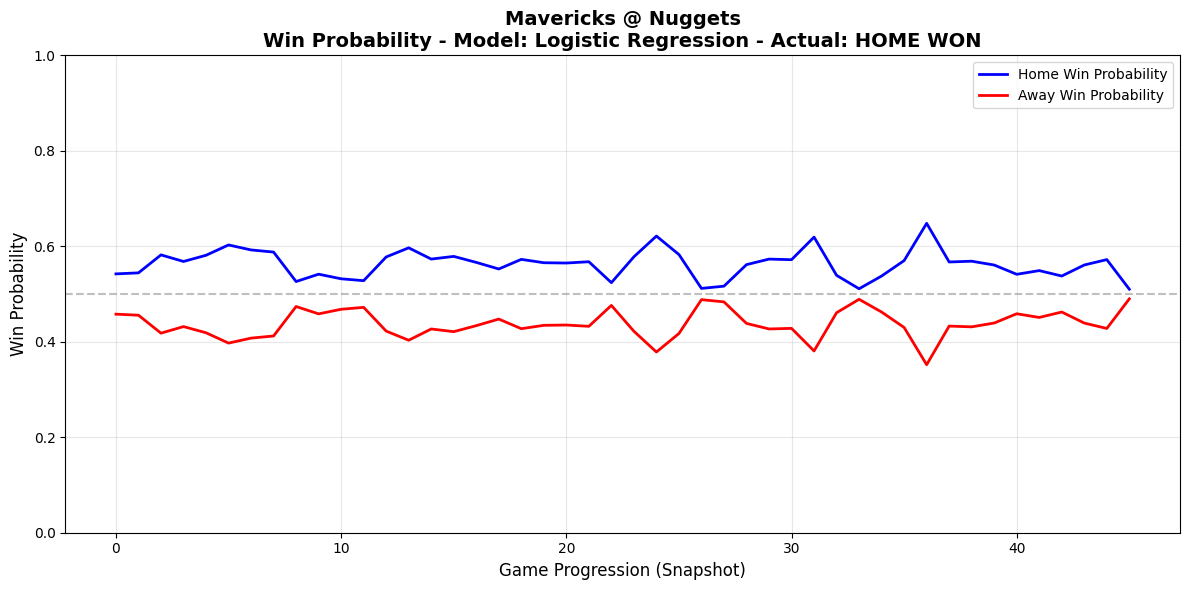

Game: Mavericks @ Nuggets
Final prediction: 51.0% home win, 49.0% away win
Actual outcome: HOME WON


In [112]:
# Now plot with best model
import matplotlib.pyplot as plt

# Check if we have game_id in data
if 'game_id' not in df.columns:
    print("Note: No game_id column. Using sequential snapshots as games.")
    # Create a fake game_id based on chunks of data
    df['game_id'] = df.index // 100  # Assume ~100 snapshots per game

print(f"Total games available: {df['game_id'].nunique()}")

# Pick one game from the data
sample_game_id = df['game_id'].unique()[game_index]
game_snapshots = df[df['game_id'] == sample_game_id].copy()

# Reset index to start from 0 for this game
game_snapshots = game_snapshots.reset_index(drop=True)

# Get predictions for each snapshot (use scaled data if NN)
if use_scaled:
    game_features_scaled = scaler.transform(game_snapshots[features])
    game_snapshots['home_win_prob'] = best_model.predict_proba(game_features_scaled)[:, 1]
else:
    game_snapshots['home_win_prob'] = best_model.predict_proba(game_snapshots[features])[:, 1]

game_snapshots['away_win_prob'] = 1 - game_snapshots['home_win_prob']

# Get team names if available
if 'home_team' in game_snapshots.columns and 'away_team' in game_snapshots.columns:
    home_team = game_snapshots['home_team'].iloc[0]
    away_team = game_snapshots['away_team'].iloc[0]
    teams_text = f"{away_team} @ {home_team}"
else:
    teams_text = "Home vs Away"

# Create plot
plt.figure(figsize=(12, 6))

plt.plot(game_snapshots.index, game_snapshots['home_win_prob'], 
         label='Home Win Probability', linewidth=2, color='blue')
plt.plot(game_snapshots.index, game_snapshots['away_win_prob'], 
         label='Away Win Probability', linewidth=2, color='red')

plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Game Progression (Snapshot)', fontsize=12)
plt.ylabel('Win Probability', fontsize=12)
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)

actual_outcome = "HOME WON" if game_snapshots['home_won'].iloc[-1] == 1 else "AWAY WON"
plt.title(f'{teams_text}\nWin Probability - Model: {best_model_name} - Actual: {actual_outcome}', 
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Game: {teams_text}")
print(f"Final prediction: {game_snapshots['home_win_prob'].iloc[-1]:.1%} home win, {1-game_snapshots['home_win_prob'].iloc[-1]:.1%} away win")
print(f"Actual outcome: {actual_outcome}")

In [113]:
# Create summary table for all games
game_summary = []

for game_id in df['game_id'].unique():
    game_data = df[df['game_id'] == game_id].copy()
    
    # Get team names
    if 'home_team' in game_data.columns and 'away_team' in game_data.columns:
        home_team = game_data['home_team'].iloc[0]
        away_team = game_data['away_team'].iloc[0]
    else:
        home_team = 'Home'
        away_team = 'Away'
    
    # Get final snapshot
    final_snapshot = game_data.iloc[-1]
    
    # Get prediction
    if use_scaled:
        final_features_scaled = scaler.transform(game_data[features].iloc[-1:])
        final_prob = best_model.predict_proba(final_features_scaled)[0, 1]
    else:
        final_prob = best_model.predict_proba(game_data[features].iloc[-1:])[0, 1]
    
    # Get actual outcome
    actual_won = final_snapshot['home_won']
    
    game_summary.append({
        'Game': f"{away_team} @ {home_team}",
        'Predicted Home Win %': f"{final_prob:.1%}",
        'Actual Result': 'HOME WON' if actual_won == 1 else 'AWAY WON',
        'Correct?': '1' if (final_prob >= 0.5) == actual_won else '0'
    })

summary_df = pd.DataFrame(game_summary)

print("\n" + "="*100)
print("ALL GAMES SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))

# Calculate overall accuracy
correct = summary_df['Correct?'].value_counts().get('1', 0)
total = len(summary_df)
print("\n" + "="*100)
print(f"Overall Prediction Accuracy: {correct}/{total} ({correct/total:.1%})")
print("="*100)


ALL GAMES SUMMARY
                        Game Predicted Home Win % Actual Result Correct?
             Rockets @ 76ers                58.5%      AWAY WON        0
       Hawks @ Trail Blazers                55.2%      HOME WON        1
              Hawks @ Knicks                45.1%      AWAY WON        1
             Hawks @ Pistons                55.3%      HOME WON        1
               Bulls @ Bucks                54.2%      AWAY WON        0
        Kings @ Timberwolves                49.9%      AWAY WON        1
            Nets @ Cavaliers                56.2%      HOME WON        1
                 Suns @ Heat                55.5%      HOME WON        1
             Warriors @ Jazz                57.5%      AWAY WON        0
            Suns @ Mavericks                42.3%      AWAY WON        1
         Mavericks @ Nuggets                51.0%      HOME WON        1
        Pelicans @ Mavericks                67.6%      HOME WON        1
     Timberwolves @ Warriors    